In [6]:
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
#turns seconds into a string format ffmpeg uses
def seconds_formatter(sec):
    x = "0" + str(datetime.timedelta(seconds=sec))[:-3]
    return x
seconds_formatter(175.305)

In [46]:
df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\gpDeepCut_resnet50_goprofrontviewJun17shuffle1_30001.h5")
#remove extra level "scorer"
df.columns = df.columns.droplevel()
df.describe()

bodyparts       leftEar                                  rightEar  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         418.129470    104.092916      0.819854    342.438231   
std           59.484658     55.269955      0.345757     61.201473   
min           -0.232820      0.058952      0.000652      1.185614   
25%          410.203378     75.918766      0.963633    317.790530   
50%          431.752412    109.551635      0.999844    332.283849   
75%          443.193016    141.584548      0.999973    346.850670   
max          651.580333    398.199630      0.999999    609.912476   

bodyparts                                      Nose                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         101.684238      0.801598    375.327111    208.523040   
std           58.679316      0.350441     59.976627     70.090319   
min           -2.496538      0.001448      0.344874     18.644475   
25%           64.836136      0.799568    366.916633    149.775522   
50%          103.500209      0.999885    382.856600    222.712812   
75%          142.310630      0.999981    389.395545    261.157506   
max          346.226936      0.999999    623.018394    397.013597   

bodyparts                    leftHand      ...          rightHand  \
coords       likelihood             x      ...         likelihood   
count      24320.000000  24320.000000      ...       24320.000000   
mean           0.789948    401.102718      ...           0.459706   
std            0.335402     42.124632      ...           0.409989   
min            0.002590     64.313986      ...           0.001246   
25%            0.663167    382.997393      ...           0.045521   
50%            0.996328    403.306821      ...           0.325276   
75%            0.999806    426.271711      ...           0.952850   
max            0.999998    652.821492      ...           0.999980   

bodyparts      leftFoot                                 rightFoot  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         400.000369    211.809658      0.563731    325.880319   
std          106.976893     68.213118      0.431094     36.197824   
min           70.790897      4.613057      0.002174      1.576407   
25%          395.883299    152.843292      0.087321    305.209249   
50%          438.449283    214.538742      0.681825    319.431005   
75%          455.452176    224.842714      0.999839    335.237931   
max          654.890787    395.073073      0.999997    646.668256   

bodyparts                                    pellet                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         193.638297      0.801919    391.551464    295.535599   
std           42.793461      0.327147     38.246815     62.200636   
min            1.647910      0.003355      1.279912      0.627747   
25%          152.980904      0.679855    392.289892    267.040393   
50%          211.355771      0.997711    395.490041    325.472089   
75%          224.876223      0.999907    397.825792    335.043683   
max          396.876828      0.999999    641.452611    395.651502   

bodyparts                
coords       likelihood  
count      24320.000000  
mean           0.634827  
std            0.460287  
min            0.001884  
25%            0.025175  
50%            0.999050  
75%            0.999830  
max            0.999988  

[8 rows x 24 columns]

In [144]:
def frame_to_time(frame):
    total_seconds = (frame/24320)*202
    return round(total_seconds, 3)
def time_to_frame(time):
    return 24320*(time/202)

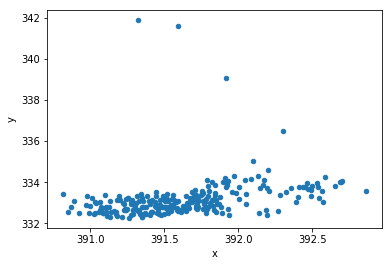

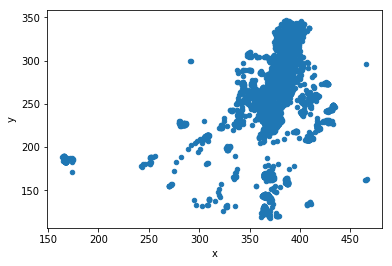

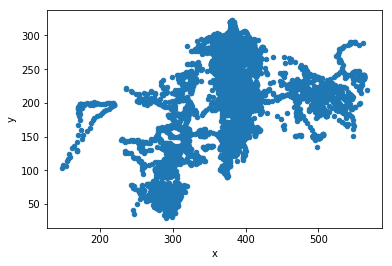

In [145]:
labels = {key: df[df[key, 'likelihood'] > 0.9][key] for key in list(df.columns.levels[0])}
{labels[key].insert(0, "frame", labels[key].index, True) for key in labels.keys()}
{labels[key].insert(0, "time", labels[key]['frame'].map(frame_to_time), True) for key in labels.keys()}
leftEar = labels['leftEar']
rightEar = labels['rightEar']
nose = labels['Nose']
leftHand = labels['leftHand']
rightHand = labels['rightHand']
leftFoot = labels['leftFoot']
rightFoot = labels['rightFoot']
pellet = labels['pellet']
pellet[(pellet['time'] > 22.5) & (pellet['time'] < 25)].plot(kind='scatter', x='x', y='y')
rightHand.plot(kind='scatter', x='x', y='y')
nose.plot(kind='scatter', x='x', y='y')

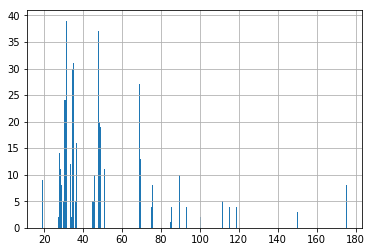

In [146]:
def dist_from_dispenser(x, y):
    return ((x-405)**2 + (y-347.5)**2)**0.5
rightHand['d_from_dispenser'] = rightHand.apply(lambda row: dist_from_dispenser(x = row['x'], y = row['y']), axis=1)
hand_reach2 = rightHand[rightHand['d_from_dispenser'] < 35]
hand_reach2['time'].hist(bins=300)


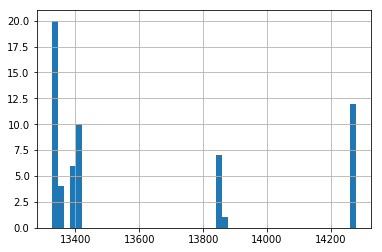

In [147]:
hand_reach2 = rightHand[(rightHand['d_from_dispenser'] < 45)& (rightHand['time'] < 120) & (rightHand['time'] > 109)]
hand_reach2['frame'].hist(bins=50)

In [166]:
hand_reach2 = rightHand[rightHand['d_from_dispenser'] < 40]
def get_reaches():
    reaches = []
    last_frame = hand_reach2['frame'].values[0]
    consec_frames_ct = 1 #number of consecutive frames
    first_frame_of_reach = last_frame
    for frame in hand_reach2['frame'].values:
        if (frame - last_frame < 10):
            consec_frames_ct += 1
        else:
            reaches.append((first_frame_of_reach, consec_frames_ct))
            consec_frames_ct = 1
            first_frame_of_reach = frame
        last_frame = frame
    reaches.append((first_frame_of_reach, consec_frames_ct))
    
    #filter out false positives: reaches that only lasted 2 frames
    reaches2 = [x for x in reaches if x[1] > 3]
    reaches2_time = [(frame_to_time(x[0]), frame_to_time(x[1])) for x in reaches2]
    return reaches2_time
get_reaches()

[(18.938, 0.091),
 (27.434, 0.075),
 (28.157, 0.233),
 (28.722, 0.282),
 (30.35, 0.274),
 (30.981, 0.449),
 (33.431, 0.15),
 (34.088, 0.266),
 (34.827, 0.772),
 (36.172, 0.141),
 (44.96, 0.125),
 (45.658, 0.166),
 (47.701, 0.341),
 (48.457, 0.357),
 (51.073, 0.116),
 (68.507, 0.257),
 (69.138, 0.166),
 (75.144, 0.05),
 (75.592, 0.108),
 (84.554, 0.033),
 (85.119, 0.108),
 (89.629, 0.133),
 (93.151, 0.058),
 (100.493, 0.042),
 (110.693, 0.042),
 (111.308, 0.066),
 (114.979, 0.05),
 (118.534, 0.05),
 (146.001, 0.033),
 (149.905, 0.042),
 (175.305, 0.075)]

In [237]:
#Open up new batch file
project_name = "goprofrontview"
bat_file= r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}_create_videos.bat".format(project_name)
script_writer= open(bat_file,"w")

#write series of shell commands to create videos for each attempt, connected by '&&' for the batch file
reaches = get_reaches()
vids = []
for tpl in reaches:
    start_time = seconds_formatter(max(0, tpl[0] - 2))
    cmd = "ffmpeg -i gp.mp4 -ss {0} -t {1} -c copy {2}.mp4".format(start_time, 3 + tpl[1], np.round(tpl[0], 3))
    vids.append(str(np.round(tpl[0], 3)) + ".mp4")
    script_writer.write(cmd + " && ")
script_writer.close()

#open and write a list of videos to concatenate (.txt file) for ffmpeg to use
list_file = r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}_video_list.txt".format(project_name)
list_writer = open(list_file, "w+")
for v in vids:
    list_writer.write('file ' + "\'" + r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}".format(v) + "\'\n")
list_writer.close()

#open batch file again and write command to produce a concatenated video, the final product
script_writer = open(bat_file, "a+")
script_writer.write("ffmpeg -f concat -safe 0 -i {0} -c copy output.mp4".format(list_file))
script_writer.close()